# A heterogeneous-risk model estimation using SCE


## Motivation

So it has been established that PR shows a large degree of heterogeneity and it is along dimensions beyond the conventional assumptions. So the questions are how am I about to model this heterogeneity, estimating them from survey data and also acccount for the empirical regularities.

In reality, the income process could differ in various different ways. But a simple assumption is enough. I assume that the relative size of permanent and transitory risks are heterogeneous. This easily accomodates various kinds of reasons for the heterogeneity in income risks. 

In [15]:
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
import pandas as pd
import copy as cp
plt.style.use('ggplot')
from scipy.optimize import fsolve
import pickle 

## figure plotting configurations

plt.style.use('seaborn')
plt.rcParams["font.family"] = "Times New Roman" #'serif'
plt.rcParams['font.serif'] = 'Ubuntu'
plt.rcParams['font.monospace'] = 'Ubuntu Mono'
plt.rcParams['axes.labelweight'] = 'bold'

## Set the 
plt.rc('font', size=25)
# Set the axes title font size
plt.rc('axes', titlesize=20)
# Set the axes labels font size
plt.rc('axes', labelsize=20)
# Set the font size for x tick labels
plt.rc('xtick', labelsize=20)
# Set the font size for y tick labels
plt.rc('ytick', labelsize=20)
# Set the legend font size
plt.rc('legend', fontsize=20)
# Set the font size of the figure title
plt.rc('figure', titlesize=20)

In [16]:
## a test of fitting fake log normal data 

sigma_fake = 0.4
mu_fake = - sigma_fake**2/2
mean_one_log_normal_draws = np.exp(np.random.randn(100000)*sigma_fake-sigma_fake**2/2)

## fit 
from scipy import stats
shape, loc, scale = stats.lognorm.fit(mean_one_log_normal_draws,floc=0)
mu_fake_est, sigma_fake_est= np.log(scale), shape  # mu, sigma ## mu=-sigma^2/2 for mean-one log normal

print('true mu:',str(mu_fake))
print('true sigma:',str(sigma_fake))

print('est mu:',str(mu_fake_est))
print('est sigma:',str(sigma_fake_est))
print('est loc:',str(loc))

true mu: -0.08000000000000002
true sigma: 0.4
est mu: -0.08031437809935381
est sigma: 0.39923884984040575
est loc: 0.0


In [17]:
def Est_PR_log_normal_simple(PRs,
                             est_PR):
    """
    input
    =====
    PRs: an array of individual PRs
    est_PR: a scalar of average PR estimated from Panel data 
    
    output
    ======
    an array storing 3 parameters 
    mu_PR_est: the estimated mean of the PR in population 
    sigma_PR_est: the estimated stadanrd deviation of PR in population
    sigma_xi_est: the estimated unobserved heterogeneity 
    
    """
    
    ## PR log normal 
    
    shape, loc, scale = stats.lognorm.fit(PRs, 
                                          floc=0)
    mu_PR_est, sigma_PR_est= np.log(scale), shape  # mu, sigma ## mu=-sigma^2/2 for mean-one log normal 
    
    av_PRs = np.mean(PRs)
    ## Estimating the wedge 
    sigma_xi_est = np.sqrt(est_PR - av_PRs)
    
    #PRs_transform = PRs/est_sigma_tran**2-1 
    
    
    return np.array([mu_PR_est,sigma_PR_est,sigma_xi_est])

## Estimation using SCE data


In [18]:
dataset = pd.read_stata('../SurveyData/SCE/IncExpSCEProbIndM.dta')   

## variables 
vars_id = ['userid','date']
moms_nom = ['Q24_mean','Q24_iqr','Q24_var']
moms_real = ['Q24_rmean','Q24_rvar']
ue_risks = ['Q13new','Q22new']
vars_demog = ['D6']   ## level of income, 11 groups 

vars_job = ['Q10_1',  # full-time 
            'Q10_2',  # part-time
            'Q12new'] ## =1 worked for others; = 2 self-employment 

vars_demog_sub = ['Q32',  ## age 
                  'Q33',  ## gender 
                  'Q36',  ## education (1-8 low to high, 9 other)
                  'educ_gr',##education group (1-3)
                  'byear', ## year of birth
                  'tenure', ## nb of months staying in the survey 
                   'nlit'] 

vars_all_reg_long = (vars_id+moms_nom + moms_real+ue_risks+vars_demog+vars_demog_sub+vars_job)

## select dataset 
SCEM = dataset[vars_all_reg_long]

SCEM = SCEM.rename(columns={'Q24_mean': 'incexp',
                           'Q24_var': 'incvar',
                           'Q24_iqr': 'inciqr',
                           'Q24_rmean':'rincexp',
                           'Q24_rvar': 'rincvar',
                           'Q13new':'UE_s',
                           'Q22new':'UE_f'
                           })

SCEM = SCEM.rename(columns = {'D6':'HHinc',
                              'Q10_1':'fulltime',
                              'Q10_2':'parttime',
                              'Q12new':'selfemp',
                              'Q32':'age',
                              'Q33':'gender',
                              'Q36':'educ'})

SCEM = SCEM.dropna(subset=['date'])

## filter by basic/necessary criteria  
print('nb of observations before:',str(len(SCEM)))
SCEM = SCEM[SCEM['tenure']>=3]
SCEM = SCEM[SCEM['fulltime']==1]
SCEM = SCEM[SCEM['selfemp']==1]  ## working for someone 
SCEM =SCEM[(SCEM['age']<=65) & (SCEM['age']>=25) ]
SCEM =SCEM[SCEM['nlit']>=2.0]
SCEM =SCEM[SCEM['educ']>=1]
print('nb of observations after dropping low numeracy/low education sample:',str(len(SCEM)))

nb of observations before: 115083
nb of observations after dropping low numeracy/low education sample: 32541


In [19]:
## first obtain time average by individual 

PR_ind_av = SCEM.groupby('userid')['rincvar'].mean().dropna()

PR_ind_av = SCEM.groupby('userid')['rincvar'].mean().dropna()

In [20]:
## some commonly used parameters, e.g. from Low et al.

sigma_perm_Low_est = 0.1
print('Estimated perm risk', str(sigma_perm_Low_est))
sigma_tran_Low_est = 0.08
print('Estimated tran risk', str(sigma_tran_Low_est))
est_PR_Low = sigma_perm_Low_est**2 + sigma_tran_Low_est**2
print('Implied Estimated PR in std term', str(np.sqrt(est_PR_Low)))

PRs_SCE = np.array(PR_ind_av)
av_PR_SCE = np.mean(PR_ind_av)

print('Average PR in SCE', str(np.sqrt(av_PR_SCE)))

Estimated perm risk 0.1
Estimated tran risk 0.08
Implied Estimated PR in std term 0.12806248474865697
Average PR in SCE 0.03567073296643721


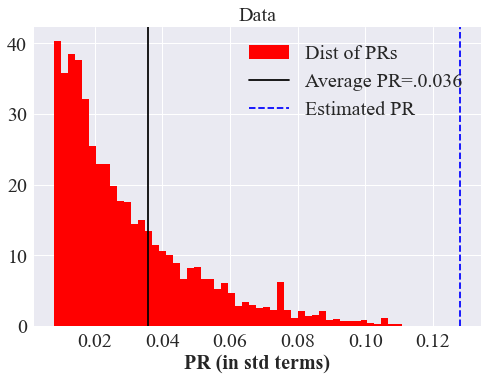

In [21]:
## distributions of PR 

plt.title('Data')

hist = plt.hist(np.sqrt(PRs_SCE),
                bins = 50,
                color='red',
                label='Dist of PRs',
               density=True)

plt.axvline(np.sqrt(av_PR_SCE),
            color='black',
            label='Average PR=.{:.3f}'.format(np.sqrt(av_PR_SCE)))

plt.axvline(np.sqrt(est_PR_Low),
            linestyle='--',
            color='blue',
            label='Estimated PR')

plt.xlabel('PR (in std terms)')
plt.legend(loc=1)

In [22]:
## estimating the parameters using SCE 

mu_PR_est_SCE, sigma_PR_est_SCE,sigma_xi_est_SCE = Est_PR_log_normal_simple(PRs_SCE,
                                                                            est_PR_Low)
print('Estimated mean PR',str(mu_PR_est_SCE))
print('Estimated standard deviation in PR',str(sigma_PR_est_SCE))
print('Estimated wedge due to unobserved heterogeneity',str(sigma_xi_est_SCE))

PRs_sim_simple = np.exp(np.random.randn(10000)*sigma_PR_est_SCE+mu_PR_est_SCE)

Estimated mean PR -7.432702541351318
Estimated standard deviation in PR 1.2520112991333008
Estimated wedge due to unobserved heterogeneity 0.1229943120176604


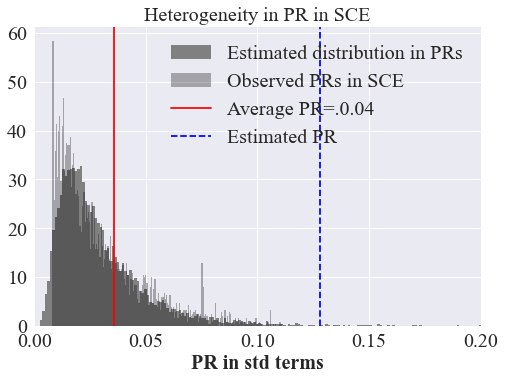

In [24]:
## plot simulated data based on log normal estimates and the observed PRs

plt.title('Heterogeneity in PR in SCE')
plt.hist(np.sqrt(PRs_sim_simple),
        bins = 200,
         color='gray',
        label='Estimated distribution in PRs',
        density = True)

plt.hist(np.sqrt(PRs_SCE),
         bins = 200,
         color='black',
         label='Observed PRs in SCE',
         density = True,
         alpha=0.3)

plt.axvline(np.sqrt(av_PR_SCE),
            color='red',
            label='Average PR=.{:.2f}'.format(np.sqrt(av_PR_SCE)))

plt.axvline(np.sqrt(est_PR_Low),
            linestyle='--',
            color='blue',
            label='Estimated PR')

plt.xlim([0.0,0.2])
plt.xlabel('PR in std terms')
plt.legend(loc=1)
plt.savefig('../Graphs/sce/log_normal_fit.pdf')

In [25]:
## Create equalprobable grid for sigma_permanent and sigma_transitory 

In [ ]:
## ## store all data 
PR_est_dict = {'mu_pr':mu_PR_est_SCE,
              'sigma_pr':sigma_PR_est_SCE,
              'sigma_xi':sigma_xi_est_SCE}

pickle.dump(PR_est_dict,open('./parameters/PR_est.pkl','wb'))